In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import preprocess_input

# Assuming you have your dataset in folders named 'train', 'test', and 'val', and
# each folder contains subfolders named after class labels (here, person's names)

# Directory paths
train_dir = r'D:\thesis\train'
val_dir = r'D:\thesis\validate'
test_dir = r'D:\thesis\test'

# Image data generator with preprocessing
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Load and preprocess images
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical')

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical')

# Output the number of classes (people) in the dataset
num_classes = train_generator.num_classes
print(f"Number of classes: {num_classes}")

Found 4277 images belonging to 334 classes.
Found 992 images belonging to 334 classes.
Found 1017 images belonging to 334 classes.
Number of classes: 334


In [2]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Load InceptionV3 model pre-trained on ImageNet data
base_model = InceptionV3(weights='imagenet', include_top=False)

# Add new layers on top for face recognition
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)  # Large Dense layer
predictions = Dense(num_classes, activation='softmax')(
    x)  # num_classes is the number of people

# This is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze all layers in the base InceptionV3 model
for layer in base_model.layers:
    layer.trainable = False

87910968/87910968 [==============================] - 124s 1us/step


Epoch 1/50
100/100 [==============================] - 42s 388ms/step - loss: 4.0706 - accuracy: 0.1419 - val_loss: 3.5577 - val_accuracy: 0.1987
Epoch 2/50
100/100 [==============================] - 38s 382ms/step - loss: 2.9289 - accuracy: 0.3162 - val_loss: 2.8116 - val_accuracy: 0.3304
Epoch 3/50
100/100 [==============================] - 38s 375ms/step - loss: 2.1868 - accuracy: 0.4641 - val_loss: 2.4401 - val_accuracy: 0.3850
Epoch 4/50
100/100 [==============================] - 38s 375ms/step - loss: 1.6275 - accuracy: 0.5953 - val_loss: 2.1616 - val_accuracy: 0.4576
Epoch 5/50
100/100 [==============================] - 37s 367ms/step - loss: 1.3034 - accuracy: 0.6576 - val_loss: 1.8005 - val_accuracy: 0.5379
Epoch 6/50
100/100 [==============================] - 37s 371ms/step - loss: 0.9724 - accuracy: 0.7566 - val_loss: 1.6987 - val_accuracy: 0.5670
Epoch 7/50
100/100 [==============================] - 36s 360ms/step - loss: 0.7598 - accuracy: 0.8097 - val_loss: 1.5534 - val_ac

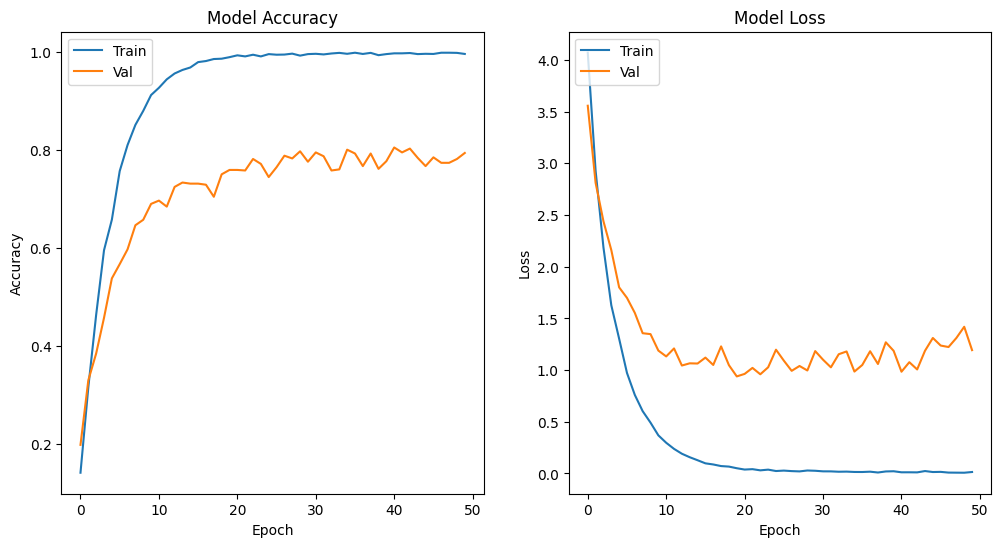

In [4]:
import matplotlib.pyplot as plt
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model (adjust epochs and steps_per_epoch as needed)
history = model.fit(
    train_generator,
    steps_per_epoch=100,  # depends on your data
    epochs=50,  # can be adjusted
    validation_data=val_generator,
    validation_steps=28)  # depends on your data

model.save('my_inception1.h5')


# Evaluate the model
eval_result = model.evaluate(test_generator)
print(f"Test Loss: {eval_result[0]}, Test Accuracy: {eval_result[1]}")

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.show()

In [5]:
val_accuracy = history.history['val_accuracy'][-1]
print(f"Validation Accuracy: {val_accuracy}")

Validation Accuracy: 0.7935267686843872


In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

# Constants
IMG_SIZE = 299
BATCH_SIZE = 32

# Load your trained model
model = tf.keras.models.load_model(r'D:\thesis\codes\my_inception1.h5')

# Data generator for the test set
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    r'D:\thesis\test',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False)

# Predict the output on the test set
test_generator.reset()
predictions = model.predict(test_generator, steps=len(test_generator))
predicted_classes = np.argmax(predictions, axis=1)

# True labels
true_classes = test_generator.classes

# Calculate Precision, Recall, and F1 Score with zero_division parameter
precision = precision_score(
    true_classes, predicted_classes, average='macro', zero_division=0)
recall = recall_score(true_classes, predicted_classes,
                      average='macro', zero_division=0)
f1 = f1_score(true_classes, predicted_classes,
              average='macro', zero_division=0)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Found 1017 images belonging to 334 classes.
32/32 [==============================] - 17s 375ms/step
Precision: 0.5008284945260993
Recall: 0.45583832335329344
F1 Score: 0.42651516872243533
